In [248]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, cv, Pool
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_absolute_percentage_error
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)

In [233]:
df_1 = pd.read_json('DATASET_FINAL.json')

df = df_1.copy()

In [234]:
# Groupement des acteurs 1, 2, 3 , scénaristes, réalisateurs, et distributeurs qui font plus de 500k entrées 
# + ajout d'un groupe "mid" entre 250k et 500k

# Acteur 1
df_actor_1 = df.groupby('actor_1')['weekly_entrances'].mean().reset_index()
df_actor_1_mid = df_actor_1[(df_actor_1['weekly_entrances'] < 500001) & (df_actor_1['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_1 = df_actor_1[df_actor_1['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 2
df_actor_2 = df.groupby('actor_2')['weekly_entrances'].mean().reset_index()
df_actor_2_mid = df_actor_2[(df_actor_2['weekly_entrances'] < 500001) & (df_actor_2['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_2 = df_actor_2[df_actor_2['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Acteur 3
df_actor_3 = df.groupby('actor_3')['weekly_entrances'].mean().reset_index()
df_actor_3_mid = df_actor_3[(df_actor_3['weekly_entrances'] < 500001) & (df_actor_3['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_actor_3 = df_actor_3[df_actor_3['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Réalisateurs
df_directors = df.groupby('directors')['weekly_entrances'].mean().reset_index()
df_directors_mid = df_directors[(df_directors['weekly_entrances'] < 500001) & (df_directors['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_directors = df_directors[df_directors['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Scénaristes
df_writer = df.groupby('writer')['weekly_entrances'].mean().reset_index()
df_writer_mid = df_writer[(df_writer['weekly_entrances'] < 500001) & (df_writer['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_writer = df_writer[df_writer['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)

# Distributeurs
df_distribution = df.groupby('distribution')['weekly_entrances'].mean().reset_index()
df_distribution_mid = df_distribution[(df_distribution['weekly_entrances'] < 500001) & (df_distribution['weekly_entrances'] > 250000)].sort_values(by='weekly_entrances', ascending=False)
df_distribution = df_distribution[df_distribution['weekly_entrances'] > 500000].sort_values(by='weekly_entrances', ascending=False)


In [235]:
# Création des colonnes "top" et "top_mid" pour les différents groupes

df['top_actor_1'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1['actor_1'].to_list() else 0)
df['top_actor_1_mid'] = df['actor_1'].apply(lambda x: 1 if x in df_actor_1_mid['actor_1'].to_list() else 0)

df['top_actor_2'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2['actor_2'].to_list() else 0)
df['top_actor_2_mid'] = df['actor_2'].apply(lambda x: 1 if x in df_actor_2_mid['actor_2'].to_list() else 0)

df['top_actor_3'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3['actor_3'].to_list() else 0)
df['top_actor_3_mid'] = df['actor_3'].apply(lambda x: 1 if x in df_actor_3_mid['actor_3'].to_list() else 0)

df['top_director'] = df['directors'].apply(lambda x: 1 if x in df_directors['directors'].to_list() else 0)
df['top_director_mid'] = df['directors'].apply(lambda x: 1 if x in df_directors_mid['directors'].to_list() else 0)

df['top_writer'] = df['writer'].apply(lambda x: 1 if x in df_writer['writer'].to_list() else 0)
df['top_writer_mid'] = df['writer'].apply(lambda x: 1 if x in df_writer_mid['writer'].to_list() else 0)

df['top_distribution'] = df['distribution'].apply(lambda x: 1 if x in df_distribution['distribution'].to_list() else 0)
df['top_distribution_mid'] = df['distribution'].apply(lambda x: 1 if x in df_distribution_mid['distribution'].to_list() else 0)


In [239]:
features_of_interest = [
    # "actor_1",
    # "actor_2",
    # 'actor_3',
    # "directors",
    #  "writer",
    # "distribution",
    'released_year',
    "country",
    "budget",
    'category',
    'classification',
    'duration_minutes', 
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    'top_distribution',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid'
]


numerical_column = [
    "budget",
    'released_year',
    "duration_minutes",
]


ordinal_column = [
    "top_actor_1",
    "top_actor_2",
    "top_actor_3",
    "top_director",
    'top_writer',
    "top_actor_1_mid",
    "top_actor_2_mid",
    "top_actor_3_mid",
    "top_director_mid",
    'top_writer_mid',
    'top_distribution_mid',
    'top_distribution'
]

categorical_column = [
        # "actor_1",
        # "actor_2",
        # "actor_3",
        # "directors",
        # "writer",
        # "distribution",
    "country",
    'category',
    'classification',
]


target_name = "weekly_entrances"
data, target, numerical_data,categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[categorical_column]
)


In [240]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.85, random_state=42)

In [241]:
X_train.dtypes

released_year            int64
country                 object
budget                   int64
category                object
classification          object
duration_minutes         int64
top_actor_1              int64
top_actor_2              int64
top_actor_3              int64
top_director             int64
top_writer               int64
top_distribution         int64
top_actor_1_mid          int64
top_actor_2_mid          int64
top_actor_3_mid          int64
top_director_mid         int64
top_writer_mid           int64
top_distribution_mid     int64
dtype: object

In [250]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_column),
    ("numeric", RobustScaler(), numerical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column)
    ],
    remainder="passthrough",
)

catboost_model = make_pipeline(preprocessor, CatBoostRegressor())
catboost_model.fit(X_train,y_train)

# Prédictions sur le test
y_pred = catboost_model.predict(X_test)

# Calcul des métriques
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
errors = y_pred - y_test
sum_errors = np.sum(errors)
mean_errors = np.mean(errors)
print(f"✅ RMSE (test) Catboost: {rmse:.4f}")
print(f"✅ MAPE (test) Catboost: {mape:.4f}")
print(f"🔥 Somme des erreurs: {sum_errors:.4f}")
print(f"🔥 moyenne des erreurs: {mean_errors:.4f}")

Learning rate set to 0.054572
0:	learn: 330149.5572973	total: 1.59ms	remaining: 1.59s
1:	learn: 318831.7474354	total: 2.94ms	remaining: 1.47s
2:	learn: 308642.6039702	total: 4.26ms	remaining: 1.42s
3:	learn: 298706.9124780	total: 5.79ms	remaining: 1.44s
4:	learn: 289458.9996362	total: 7.08ms	remaining: 1.41s
5:	learn: 281089.6879731	total: 8.64ms	remaining: 1.43s
6:	learn: 273293.2349036	total: 10ms	remaining: 1.42s
7:	learn: 265852.4248455	total: 11.4ms	remaining: 1.42s
8:	learn: 259137.9605097	total: 13ms	remaining: 1.43s
9:	learn: 252708.5678728	total: 14.3ms	remaining: 1.42s
10:	learn: 246449.3010769	total: 15.6ms	remaining: 1.4s
11:	learn: 241093.0512949	total: 16.9ms	remaining: 1.39s
12:	learn: 235787.3395367	total: 18.2ms	remaining: 1.38s
13:	learn: 231048.1419093	total: 19.6ms	remaining: 1.38s
14:	learn: 226504.8737299	total: 21ms	remaining: 1.38s
15:	learn: 222102.3728155	total: 22.6ms	remaining: 1.39s
16:	learn: 217858.9209904	total: 23.8ms	remaining: 1.38s
17:	learn: 214261.

In [243]:
import pandas as pd
import numpy as np

# Étape 1 : Extraire le modèle CatBoost et le préprocessor depuis le pipeline
fitted_preprocessor = catboost_model.named_steps["columntransformer"]
fitted_model = catboost_model.named_steps["catboostregressor"]

# Étape 2 : Récupérer tous les noms de features après transformation
# - Categorical (OneHotEncoder)
cat_feat_names = fitted_preprocessor.named_transformers_["categorical"]\
    .get_feature_names_out(categorical_column)

# - Numeric (RobustScaler)
num_feat_names = numerical_column

# - Ordinal (OrdinalEncoder)
ord_feat_names = ordinal_column

# - Autres (remainder passthrough)
# Ici on a rien en plus, donc on concatène
feature_names = np.concatenate([cat_feat_names, num_feat_names, ord_feat_names])

# Étape 3 : Récupérer les importances du modèle
importances = fitted_model.feature_importances_

# Étape 4 : Créer un DataFrame trié avec noms + importances
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("📊 Feature Importances (top 30) :")
print(feat_imp_df.head(30))

# Étape 5 : Somme des valeurs d'origine pour chaque colonne d'intérêt
print("\n🧮 Sommes des valeurs par feature (dans les données brutes) :")

for col in numerical_column + ordinal_column:
    print(f"{col:25}: {df[col].sum():,.0f}")


📊 Feature Importances (top 30) :
                              Feature  Importance
108                        top_writer   16.778161
101                            budget   12.310835
106                       top_actor_3   10.291519
103                  duration_minutes    7.774684
107                      top_director    6.947976
105                       top_actor_2    6.687627
104                       top_actor_1    6.273950
102                     released_year    5.102972
113                    top_writer_mid    3.938063
111                   top_actor_3_mid    3.177096
26                     country_France    2.934383
112                  top_director_mid    2.658261
109                   top_actor_1_mid    2.483379
110                   top_actor_2_mid    2.210915
82                   category_Fantasy    1.843345
77                   category_Comédie    1.653625
115                  top_distribution    1.138711
114              top_distribution_mid    0.899399
99    classificat

In [244]:
items_list = feat_imp_df['Feature'].unique()
to_remove = ['budget', 'top_writer', 'duration_minutes', 'top_actor_3',
             'top_actor_1', 'top_actor_2', 'top_director']

items_list = [item for item in items_list if item not in to_remove]

for category in categorical_column:

    list_sum = 0
    to_drop = []

    for cat in items_list:
        if category in cat:
            list_sum += feat_imp_df.loc[feat_imp_df['Feature'] == cat, 'Importance'].values[0]
            to_drop.append(cat)

    feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(to_drop)]

    new_row = pd.DataFrame([{'Feature': category, 'Importance': list_sum}])
    feat_imp_df = pd.concat([feat_imp_df, new_row], axis=0, ignore_index=True)

    print(f'la somme de {category} est de {list_sum}')

# Affichage final
feat_imp_df


la somme de country est de 3.4881800002073686
la somme de category est de 6.228084532577404
la somme de classification est de 1.6101867048828788


,Feature,Importance
0,top_writer,16.778161
1,budget,12.310835
2,top_actor_3,10.291519
3,duration_minutes,7.774684
4,top_director,6.947976
5,top_actor_2,6.687627
6,top_actor_1,6.273950
7,released_year,5.102972
8,top_writer_mid,3.938063
9,top_actor_3_mid,3.177096


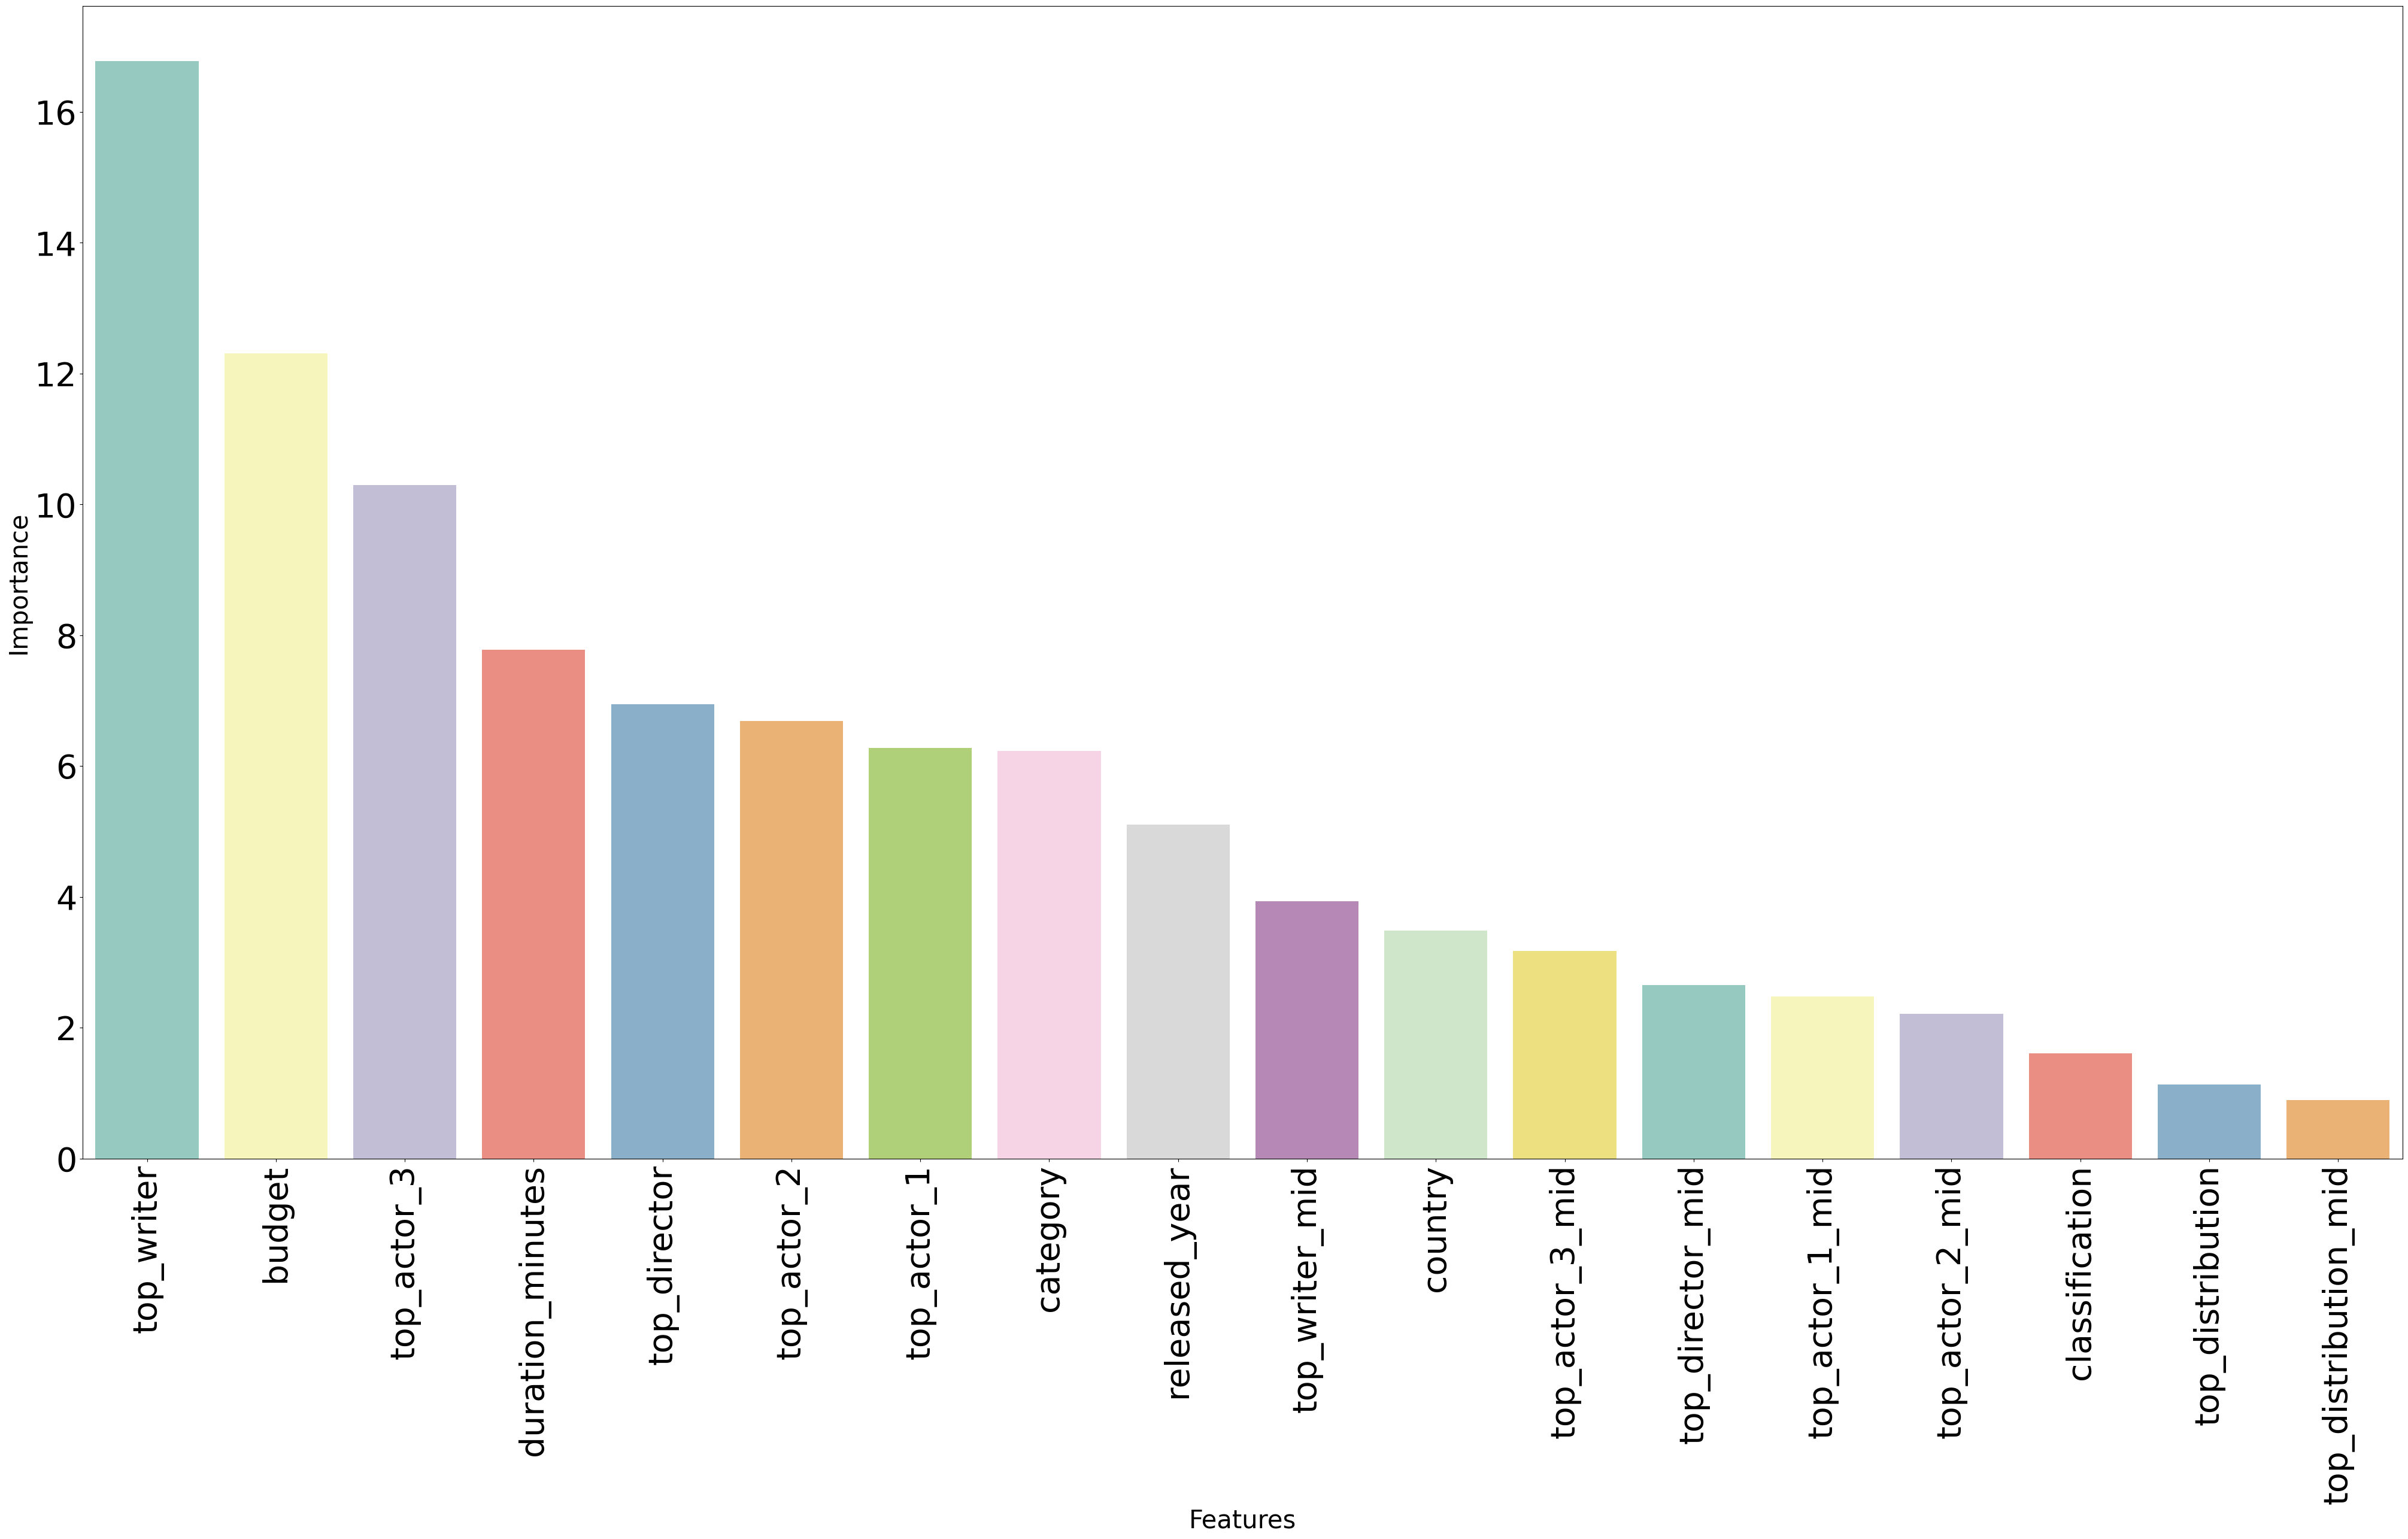

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 25))
sns.barplot(data=feat_imp_df.sort_values(by = 'Importance', ascending=False), x="Feature", y="Importance", palette="Set3")

# Labels axes
plt.xlabel("Features", fontsize=30)
plt.ylabel("Importance", fontsize=30)

# Taille des ticks
plt.tick_params(axis='both', labelsize=40)

# Rotation des labels en x si besoin (sinon tout se chevauche)
plt.xticks(rotation=90)

plt.show()


In [ ]:
df.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [ ]:
from scipy.stats import f_oneway
# Exemple de dataframe df_2_anova
df_2_anova = df.copy()



# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':  # On ne veut pas tester 'weekly_entrances' avec lui-même
        # Créer les groupes selon les valeurs de la colonne discrète
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        # Appliquer le test ANOVA
        stat_anova, p_value = f_oneway(*groups)
        
#         # # Si l'ANOVA est significative (p-value < 0.05), on applique Tukey HSD
#         # if p_value < 0.05:
#         #     # Appliquer le test post-hoc Tukey
#         #     tukey_result = pairwise_tukeyhsd(df_2_anova['weekly_entrances'], df_2_anova[column])
#         #     print(f'Post-hoc Tukey HSD pour {column}:\n', tukey_result.summary())
        
        # Afficher les résultats de l'ANOVA
        print(f'Le résultat pour {column}')
        print("Statistique F:", stat_anova)
        print("P-value:", p_value)
        print('')
        print('================================================================================')


Le résultat pour fr_title
Statistique F: 0.41652693718026995
P-value: 0.9812119563987682

Le résultat pour released_year
Statistique F: 2.9749048311426027
P-value: 1.238115635759097e-10

Le résultat pour directors
Statistique F: 1.5050970011166196
P-value: 5.003036662965276e-35

Le résultat pour writer
Statistique F: 1.4075260181823717
P-value: 8.499730665818995e-24

Le résultat pour distribution
Statistique F: 1.8537591589219735
P-value: 2.0056444949755333e-47

Le résultat pour country
Statistique F: 8.190931457293624
P-value: 1.9089757537287267e-78

Le résultat pour budget
Statistique F: 6.059394708134451
P-value: 0.0

Le résultat pour category
Statistique F: 80.04295805884722
P-value: 5.5e-321

Le résultat pour released_date
Statistique F: 1.0304036874940778
P-value: 0.22050756662100437

Le résultat pour classification
Statistique F: 44.530970788712395
P-value: 8.94625648115363e-54

Le résultat pour duration
Statistique F: 6.1697091752479984
P-value: 9.214400333780716e-108

Le résul

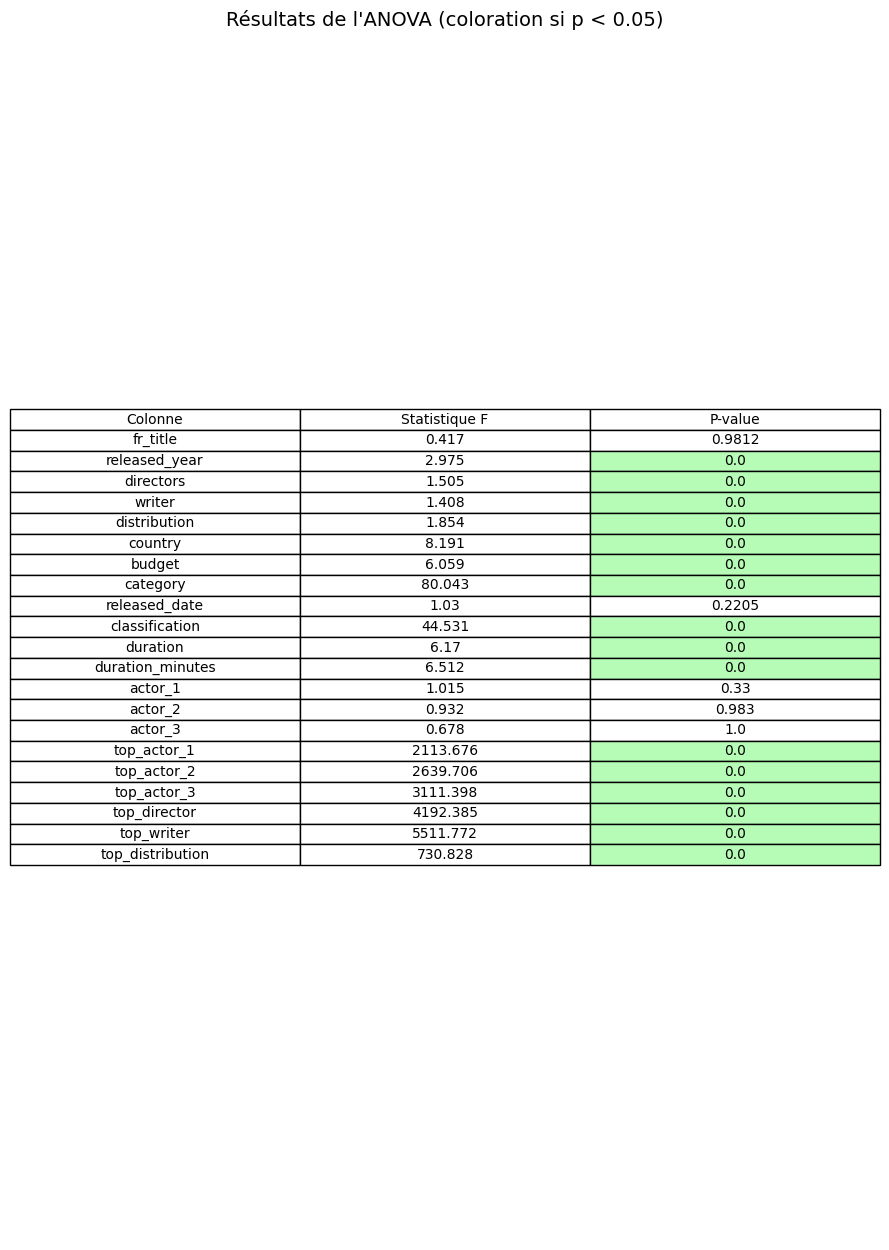

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Exemple de dataframe df_2_anova
df_2_anova = df.copy()

# Liste pour stocker les résultats
results = []

# Boucle sur les colonnes discrètes
for column in df_2_anova.columns:
    if column != 'weekly_entrances':
        groups = [df_2_anova[df_2_anova[column] == category]['weekly_entrances']
                  for category in df_2_anova[column].dropna().unique()]
        
        stat_anova, p_value = f_oneway(*groups)
        results.append([column, round(stat_anova, 3), round(p_value, 4)])  # arrondi pour lisibilité

# Créer DataFrame
results_df = pd.DataFrame(results, columns=['Colonne', 'Statistique F', 'P-value'])

# Création du tableau matplotlib
fig, ax = plt.subplots(figsize=(9, len(results_df)*0.6))
ax.axis('off')
ax.axis('tight')

# Création du tableau
table = ax.table(cellText=results_df.values,
                 colLabels=results_df.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

# Appliquer une couleur conditionnelle si p-value < 0.05
for i in range(len(results_df)):
    p_val = results_df.loc[i, 'P-value']
    if p_val < 0.05:
        # Colorier la cellule de la p-value en vert pâle
        table[(i+1, 2)].set_facecolor('#b6fcb6')  # Vert pâle

# Titre
plt.title('Résultats de l\'ANOVA (coloration si p < 0.05)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# 2. Grille de paramètres à tester (tu peux en ajouter)

param_grid = {
    'catboostregressor__depth': [4, 6, 8, 10],
    'catboostregressor__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'catboostregressor__iterations': [200, 300, 500, 700],
    'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 9],
    'catboostregressor__bagging_temperature': [0.0, 0.5, 1.0],
}


# 3. GridSearchCV
grid_search = GridSearchCV(
    catboost_model,
    param_grid,
    cv=3,  # ou 5 pour une validation croisée plus robuste
    scoring='neg_root_mean_squared_error',  # on veut minimiser le RMSE
    n_jobs=-1,
    verbose=2
)

# 4. Entraînement
grid_search.fit(X_train, y_train)

# 5. Résultats
print("✅ Best params:", grid_search.best_params_)
print(f"✅ Best RMSE: {-grid_search.best_score_:.4f}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


0:	learn: 333599.8681419	total: 52.1ms	remaining: 10.4s
1:	learn: 323705.1033624	total: 54.1ms	remaining: 5.36s
2:	learn: 314408.3169801	total: 56.7ms	remaining: 3.73s
3:	learn: 306025.2804769	total: 60.7ms	remaining: 2.97s
0:	learn: 342032.9884164	total: 52ms	remaining: 10.4s
4:	learn: 298000.2346358	total: 69.4ms	remaining: 2.71s
1:	learn: 340034.7785592	total: 64.5ms	remaining: 6.39s
2:	learn: 337941.6892585	total: 65.8ms	remaining: 4.32s
3:	learn: 335967.0167870	total: 67ms	remaining: 3.28s
5:	learn: 290587.5097069	total: 80.1ms	remaining: 2.59s
6:	learn: 283339.5052561	total: 81.5ms	remaining: 2.25s
7:	learn: 276062.2359921	total: 82.3ms	remaining: 1.98s
8:	learn: 269373.4106724	total: 86.2ms	remaining: 1.83s
9:	learn: 263189.7406148	total: 92.7ms	remaining: 1.76s
10:	learn: 257573.3336107	total: 96.3ms	remaining: 1.65s
11:	learn: 251844.9067421	total: 102ms	remaining: 1.6s
4:	learn: 334004.0224965	total: 92.9ms	remaining: 3.62s
12:	learn: 246806.8386152	total: 103ms	remaining: 1.

In [ ]:
data.columns

Index(['released_year', 'country', 'budget', 'category', 'classification',
       'duration_minutes', 'top_actor_1', 'top_actor_2', 'top_actor_3',
       'top_director', 'top_writer', 'top_distribution'],
      dtype='object')

In [ ]:
data.classification.unique()

array(['Tout public', 'Interdit - 10 ans', 'Interdit - 6 ans',
       'Interdit - 8 ans', 'Interdit - 12 ans', 'Interdit - 16 ans',
       'Interdit - 18 ans'], dtype=object)

In [ ]:
data.category.unique()

array(['Comédie', 'Science Fiction', 'Comicbook', 'Fantasy',
       'Aventure - Action', 'Guerre', 'Animation', 'Drame', 'Western',
       'Comédie dramatique', 'Thriller', 'Péplum', 'Musical',
       'Film familial', 'Romance', 'Horreur', 'Documentaire',
       'Catastrophe', 'X - Erotique', 'Adaptation Livre', 'Court-métrage',
       'Parodie', 'Action'], dtype=object)

In [ ]:
df_1.columns

Index(['fr_title', 'released_year', 'directors', 'writer', 'distribution',
       'country', 'budget', 'category', 'released_date', 'classification',
       'duration', 'weekly_entrances', 'duration_minutes', 'actor_1',
       'actor_2', 'actor_3'],
      dtype='object')

In [ ]:
import pandas as pd

# Exemple : colonnes que ton modèle attend (à adapter si besoin)
columns = [
    df_1.columns
]

# Créer un DataFrame vide avec les bonnes colonnes
df_template_test = pd.DataFrame(columns=columns)



# Ajouter un exemple de ligne (ou plusieurs)
df_1_test_film = pd.DataFrame({['fr_title' : "sinners",
                                'released_year': 2025,
                                'directors':"Ryan Coogler", 
                                'writer':"Ryan Coogler", 
                                'distribution':'Universal Pictures International France',
                                'country':'Etats-Unis',
                                 'budget': 90000000,
                                  'category':'Aventure - Action', 
                                  'released_date':"16/04/2025", 
                                  'classification':'Interdit - 12 ans',                               
                                'duration':"2h 17min", 
                                'weekly_entrances': "", 
                                'duration_minutes':137, 
                                'actor_1': "Michael B. Jordan",
                                'actor_2': "Hailee Steinfeld", 
                                'actor_3':"Miles Caton"]
})

# pred_test = catboost_model.predict(df_test)
# print("Prédiction :", round(pred_test[0]))



SyntaxError: invalid syntax (1302379671.py, line 14)